# 📓 Comprehensiveness Evaluations

In many ways, feedbacks can be thought of as LLM apps themselves. Given text, they return some result. Thinking in this way, we can use TruLens to evaluate and track our feedback quality. We can even do this for different models (e.g. gpt-3.5 and gpt-4) or prompting schemes (such as chain-of-thought reasoning).

This notebook follows an evaluation of a set of test cases generated from human annotated datasets. In particular, we generate test cases from [MeetingBank](https://arxiv.org/abs/2305.17529) to evaluate our comprehensiveness feedback function.

MeetingBank is one of the datasets dedicated to automated evaluations on summarization tasks, which are closely related to the comprehensiveness evaluation in RAG with the retrieved context (i.e. the source) and response (i.e. the summary). It contains human annotation of numerical score (**1** to **5**). 


For evaluating comprehensiveness feedback functions, we compute the annotated "informativeness" scores, a measure of how well  the summaries capture all the main points of the meeting segment. A good
summary should contain all and only the important information of the source., and normalized to **0** to **1** score as our **expected_score** and to match the output of feedback functions.

In [21]:
from test_cases import generate_meetingbank_comprehensiveness_benchmark


test_cases_gen = generate_meetingbank_comprehensiveness_benchmark(human_annotation_file_path="./datasets/meetingbank/human_scoring.json", meetingbank_file_path="/home/daniel/MeetingBank.json")
length = sum(1 for _ in test_cases_gen)
test_cases_gen = generate_meetingbank_comprehensiveness_benchmark(human_annotation_file_path="./datasets/meetingbank/human_scoring.json", meetingbank_file_path="/home/daniel/MeetingBank.json")


In [23]:
comprehensiveness_golden_set = []
for i in range(length):
    comprehensiveness_golden_set.append(next(test_cases_gen))

assert(len(comprehensiveness_golden_set) == length)

In [24]:
comprehensiveness_golden_set[:3]

[{'query': "speaker 10: Is public comment next, Madam Clerk.\nspeaker 2: And item ten is next door to. Well.\nspeaker 10: That was pulled as well.\nspeaker 2: Item ten Report from Parks, Recreation and Marine and Financial Management Recommendation to authorize the city manager to execute three new permits to operate Kiteboarding and stand up paddle boarding. Stand Up Paddle Boarding. Rental and instruction concessions on City of Long Beach Beaches District three.\nspeaker 1: Can you turn this over to Councilman Price?\nspeaker 8: Thank you. So this has been an item that we've received a lot of inquiry about over the last couple of weeks, actually, several months. But really, the the item has ramped up the discussion. So with that, I'd like to see if Parks Rec and Marine has a report to share with us that hopefully incorporate some of the\nspeaker 8: concerns that have been raised.\nspeaker 3: I'd like to hand this over to L.V. to Halloran, our bureau manager for our Marine Bureau in t

In [25]:
import os
os.environ["OPENAI_API_KEY"] = "..." # for groundtruth feedback function


In [26]:
from trulens_eval import feedback
from trulens_eval.feedback import GroundTruthAgreement
from trulens_eval import Feedback, Select, Tru

import numpy as np


tru = Tru()

provider = feedback.OpenAI(model_engine="gpt-4-turbo-preview")

In [27]:
# comprehensiveness of summary with transcript as reference
f_comprehensiveness_openai = (
    Feedback(provider.comprehensiveness_with_cot_reasons)
    .on_input_output()
    .aggregate(np.mean)
)


✅ In comprehensiveness_with_cot_reasons, input source will be set to __record__.main_input or `Select.RecordInput` .
✅ In comprehensiveness_with_cot_reasons, input summary will be set to __record__.main_output or `Select.RecordOutput` .


In [28]:
# Create a Feedback object using the numeric_difference method of the ground_truth object
ground_truth = GroundTruthAgreement(comprehensiveness_golden_set)
# Call the numeric_difference method with app and record and aggregate to get the mean absolute error
f_mae = Feedback(ground_truth.mae, name = "Mean Absolute Error").on(Select.Record.calls[0].args.args[0]).on(Select.Record.calls[0].args.args[1]).on_output()

✅ In Mean Absolute Error, input prompt will be set to __record__.calls[0].args.args[0] .
✅ In Mean Absolute Error, input response will be set to __record__.calls[0].args.args[1] .
✅ In Mean Absolute Error, input score will be set to __record__.main_output or `Select.RecordOutput` .


In [29]:
from benchmark_frameworks.eval_as_recommendation import compute_ndcg, compute_ece, recall_at_k, precision_at_k

scores = []
true_scores = [] # human prefrences / scores

In [30]:
import time
import pandas as pd


for i in range(len(comprehensiveness_golden_set)):
    source = comprehensiveness_golden_set[i]["query"]
    summary = comprehensiveness_golden_set[i]["response"]
    expected_score = comprehensiveness_golden_set[i]["expected_score"]
    feedback_score = f_comprehensiveness_openai(source, summary)[0]

    scores.append(feedback_score)
    true_scores.append(expected_score)

    end_time = time.time()

    if i % 200 == 0:
        df_results = pd.DataFrame({'scores': scores, 'true_scores': true_scores})

        # Save the DataFrame to a CSV file
        df_results.to_csv('./results/results_comprehensiveness_benchmark.csv', index=False)


   

In [32]:
ece = compute_ece([scores], [true_scores], n_bins=10) # ECE might not make much sense here as we have groundtruth in numeric values

mae = sum(abs(score - true_score) for score, true_score in zip(scores, true_scores)) / len(scores)


In [33]:
print(f"ECE: {ece}; MAE: {mae}")

ECE: 0.2151285714285715; MAE: 0.2493357142857129


In [11]:
len(true_scores)

1201

# Load / reload from previous results

In [17]:

import csv
scores = []
true_scores = []

# Open the CSV file and read its contents
with open("./results/results_comprehensiveness_benchmark.csv", 'r') as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)
    
    # Skip the header row
    next(csvreader)
    
    # Iterate over each row in the CSV
    for row in csvreader:
        # Append the scores and true_scores to their respective lists
        scores.append(float(row[0]))
        true_scores.append(float(row[1]))

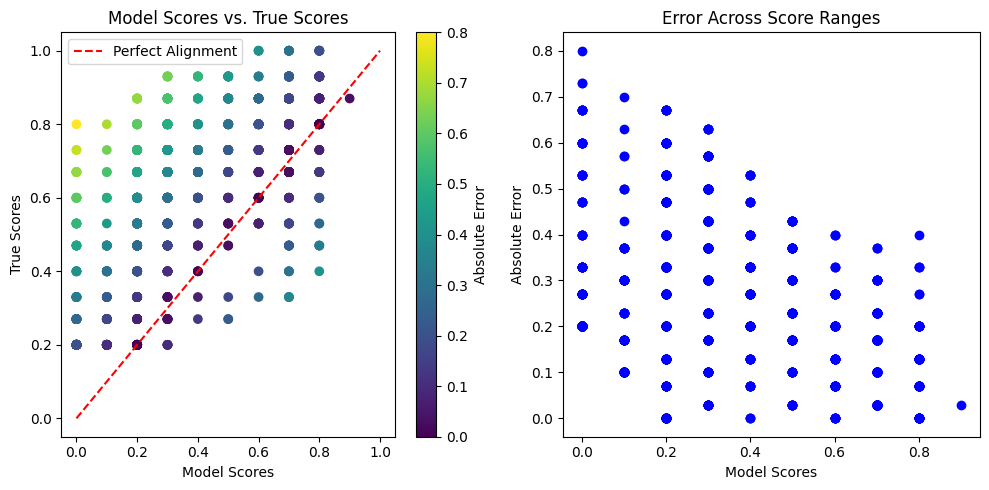

In [19]:

import matplotlib.pyplot as plt
import numpy as np


# Assuming scores and true_scores are flat lists of predicted probabilities and their corresponding ground truth relevances
# Calculate the absolute errors
errors = np.abs(np.array(scores) - np.array(true_scores))

# Scatter plot of scores vs true_scores
plt.figure(figsize=(10, 5))

# First subplot: scatter plot with color-coded errors
plt.subplot(1, 2, 1)
scatter = plt.scatter(scores, true_scores, c=errors, cmap='viridis')
plt.colorbar(scatter, label='Absolute Error')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Alignment')  # Line of perfect alignment
plt.xlabel('Model Scores')
plt.ylabel('True Scores')
plt.title('Model Scores vs. True Scores')
plt.legend()

# Second subplot: Error across score ranges
plt.subplot(1, 2, 2)
plt.scatter(scores, errors, color='blue')
plt.xlabel('Model Scores')
plt.ylabel('Absolute Error')
plt.title('Error Across Score Ranges')

plt.tight_layout()
plt.show()

